# Iris/dask dataset loading investigation

## Introduction

This demos using dask functionality beyond the `array` module to help with Iris processing. Specifically, in this notebook we will demo alternative approaches for loading numerous and/or large datasets into Iris.

Three approaches will be compared:

* The standard Iris load
* ~~Wrapping Iris load calls in a **dask bag** generated from a sequence (this is slow so will not be investigated further)~~
* Wrapping Iris load calls in a **dask bag** generated from a **delayed** call

These options will be compared with two simple metrics:

- Ease of use
- Runtime

## Setup

Below are the functions used to load the dataset. There is one function for each of the standard Iris load and the bag generated from a sequence. The bag generated from a delayed call requires two functions; one which is delayed, one to call the delayed function.

### Imports

In [1]:
import os
import time

import dask
import dask.bag as db
import dask.delayed as delayed
import iris

### Dask processing options

Define options on how dask is to process computation of graphs.

In [2]:
from distributed import Client, LocalCluster

In [5]:
lc = LocalCluster(n_workers=8)

error: [Errno 98] Address already in use

In [6]:
c = Client(lc)
c

<Client: scheduler="127.0.0.1:8786" processes=48 cores=48>

### Timer function

A simple function that records the runtime of a supplied function. This will be useful for capturing results; otherwise within this notebook we can just make use of the `%timeit` magic. 

In [7]:
def timer(func, *funcargs):
    t0 = time.time()
    func(*funcargs)
    t1 = time.time()
    return t1 - t0

### Runner functions

In [19]:
def direct_load(fp, pattern):
    """Load datasets at the filepath `fp` using Iris."""
    return iris.load(os.path.join(fp, pattern))

def delay_wrapper(fp, pattern):
    dlyd = delayed(iris.load)(os.path.join(fp, pattern))
    cs = db.from_delayed(dlyd)
#     return cs
    iris.cube.CubeList(cs.compute(get=dask.multiprocessing.get))

In [20]:
@delayed
def loader(fp):
    return iris.load(fp)

def wrapper(seq):
    cs = db.from_delayed(map(loader, seq))
#     return cs
    iris.cube.CubeList(cs.compute(get=dask.multiprocessing.get))

## Test!

Run each loader on some sample data and print the output.

Using **sample PP data** at `/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z`:

In [10]:
fp = '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z'
# fn = 'EURO4_2015060[1-3].pp'
fn = '*.pp'
seq = os.listdir(fp)
reps = 3

In [11]:
print seq

['EURO4_20150625.pp', 'EURO4_20150621.pp', 'EURO4_20150626.pp', 'EURO4_20150605.pp', 'EURO4_20150606.pp', 'EURO4_20150620.pp', 'EURO4_20150622.pp', 'EURO4_20150616.pp', 'EURO4_20150612.pp', 'EURO4_20150604.pp', 'EURO4_20150603.pp', 'EURO4_20150615.pp', 'EURO4_20150619.pp', 'EURO4_20150624.pp', 'EURO4_20150601.pp', 'EURO4_20150613.pp', 'EURO4_20150614.pp', 'EURO4_20150608.pp', 'EURO4_20150623.pp', 'EURO4_20150610.pp', 'EURO4_20150617.pp', 'EURO4_20150628.pp', 'EURO4_20150618.pp', 'EURO4_20150627.pp', 'EURO4_20150602.pp', 'EURO4_20150607.pp', 'EURO4_20150611.pp', 'EURO4_20150609.pp']


In [11]:
vals = timer(direct_load, fp, fn)
print vals

217.212347984


In [18]:
delay_vals = timer(delay_wrapper, fp, fn)
print delay_vals

0.00075101852417


In [12]:
delay_vals_v2 = timer(wrapper, [os.path.join(fp, n) for n in seq])
print delay_vals_v2

0.00382900238037


### Check the graphs

What do the graphs look like? Does this tell us why there are such differences between the two options?

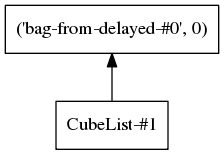

In [10]:
%matplotlib inline
delay_bag = delay_wrapper(fp, fn)
delay_bag.visualize()

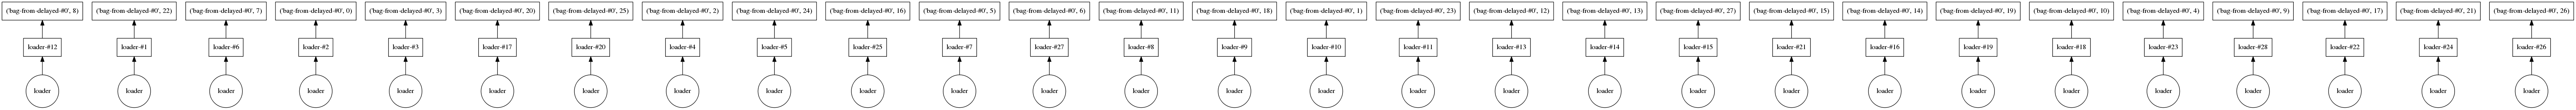

In [14]:
%matplotlib inline
delay_bag_v2 = wrapper([os.path.join(fp, n) for n in seq])
delay_bag_v2.visualize()

In [15]:
delay_bag_v2.dask

{'loader-13fd551e-4714-43fc-aaf0-f4c6eadff85e': (<function __main__.loader>,
  '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150602.pp'),
 'loader-1e7c17c9-790e-4c00-8c4f-8d662e6bed60': (<function __main__.loader>,
  '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150618.pp'),
 'loader-1fc11903-a269-411b-962a-b1467234717e': (<function __main__.loader>,
  '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150612.pp'),
 'loader-21fef1be-f439-4fad-9f7e-c73d21822345': (<function __main__.loader>,
  '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150610.pp'),
 'loader-2a8c6af1-f874-4934-a318-2607d7751b57': (<function __main__.loader>,
  '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150606.pp'),
 'loader-397cf928-1dea-454a-9110-22ef8809450a': (<function __main__.loader>,
  '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150626.pp'),
 'loader-3b8f1663-f9b6-4fe6-996d-0337967

In [ ]:
fig = plt.figure(figsize=(9, 6))
plt.boxplot([direct_load_vals_pp, delay_vals_v2_pp],
            vert=True, labels=['direct', 'delay'])
plt.show()